# Problem Description

This project's objective is to predict the probability of a flood occurring given the characteristics of the region. This outcome can be used to help cities to determine what regions are more in need of flood prevention and rescue services, as well as understanding what activities should be closely monitored based on their impact on the probability of floods.

The source of training and test data comes from the Kaggle competition **"Regression with Flood Prediction"** (https://www.kaggle.com/competitions/playground-series-s4e5/data ). This data was generated from a deep learning model.

This project uses exploratory data analysis (EDA) and supervised learning to predict the probability of a flood occuring. This project uses the regression supervised learning model.
* **Link to GitHub repo of this project**: https://github.com/squpen/supervisedML

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.api as sm

# EDA Procedure

In [14]:
# load datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

**Describing the Data**

As shown below, the training set has **size of 1117957 entries**, and the test dataset has **size of 745305 entries**.

In [47]:
# preliminary inspection of datasets
print("Training Set:")
print(df_train.head())
print(df_train.info())
print("--------------------------------------------")
print("Test Set:")
print(df_test.head())
print(df_test.info())


Training Set:
   id  MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0   0                 5                   8                5              8   
1   1                 6                   7                4              4   
2   2                 6                   5                6              7   
3   3                 3                   4                6              5   
4   4                 5                   3                2              6   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             6              4            4          3                      3   
1             8              8            3          5                      4   
2             3              7            1          5                      4   
3             4              8            4          7                      6   
4             4              4            3          3                      3   

   ...  DrainageSystems 

Preliminary analysis of distribution of flood probability.

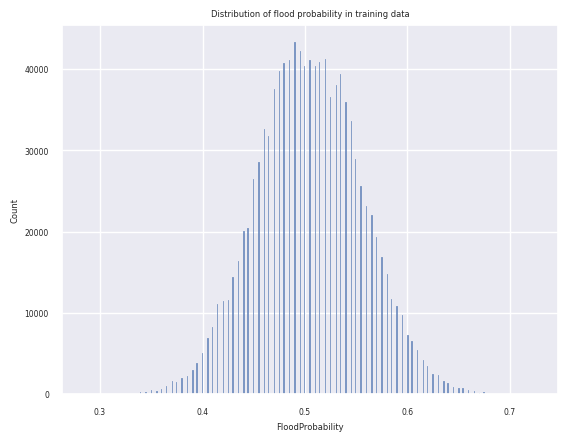

In [48]:
sns.histplot(data=df_train, x="FloodProbability")
plt.title("Distribution of flood probability in training data")
sns.set(font_scale=1)
plt.show()

**Explanation**

Inspection of the header shows that the data types of the dataframe match the feature.  Comparison the total number of entires with the non-null count of each column shows that they match for both train and test datasets. This shows there are no null values that need to be removed. Therefore, the data is already clean and does not require further removal of invalid values or data type corrections.

The histogram shows that the distribution of probabilities is broad, showing that the data is representative of a wide range of characteristics where flooding is likely and unlikely to occur.

A correlation matrix is used to understand which features might be the best predictor of the likelihood of flooding (column "FloodProbability").

In [59]:
# Analyzing correlation
df_train.corr(numeric_only=True)['FloodProbability'].sort_values()

,FloodProbability
id,-0.000184
CoastalVulnerability,0.177774
Encroachments,0.178841
DrainageSystems,0.179305
Urbanization,0.180861
InadequatePlanning,0.180968
Watersheds,0.181907
PoliticalFactors,0.182417
IneffectiveDisasterPreparedness,0.183109
AgriculturalPractices,0.183366


<function matplotlib.pyplot.show(close=None, block=None)>

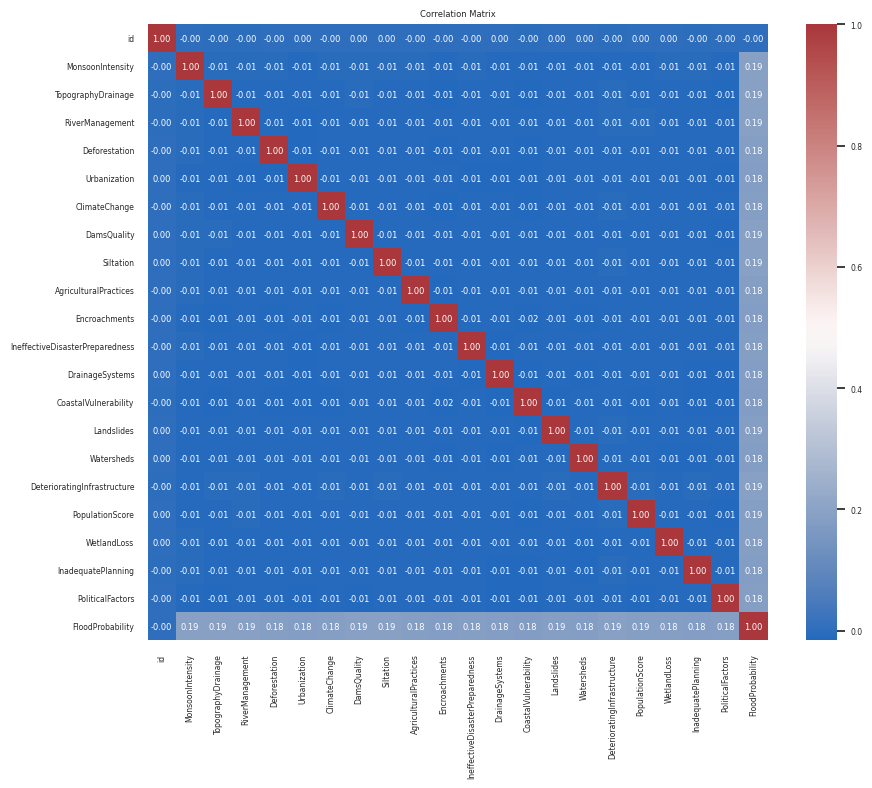

In [55]:
# Correlation matrix of features
corr_matrix = df_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='vlag')
sns.set(font_scale=0.5)
plt.title('Correlation Matrix')
plt.show

In [20]:
# Filtered training data with only top 5 features and sample subset for pairplot
df_train_filtered = df_train[df_train.corr(numeric_only=True)['FloodProbability'].sort_values(ascending=False).index[:6]]
df_train_filtered_sample = df_train_filtered.sample(n=500, random_state=0)
print(df_train_filtered_sample.head())

         FloodProbability  DeterioratingInfrastructure  MonsoonIntensity  \
274288              0.505                            5                 2   
808322              0.595                            7                 8   
555699              0.550                            3                 4   
1066543             0.615                            4                 3   
122441              0.575                           10                 6   

         DamsQuality  TopographyDrainage  RiverManagement  
274288             6                   5                8  
808322            10                   4                2  
555699             6                   7                8  
1066543            6                   8                9  
122441             5                   5               10  


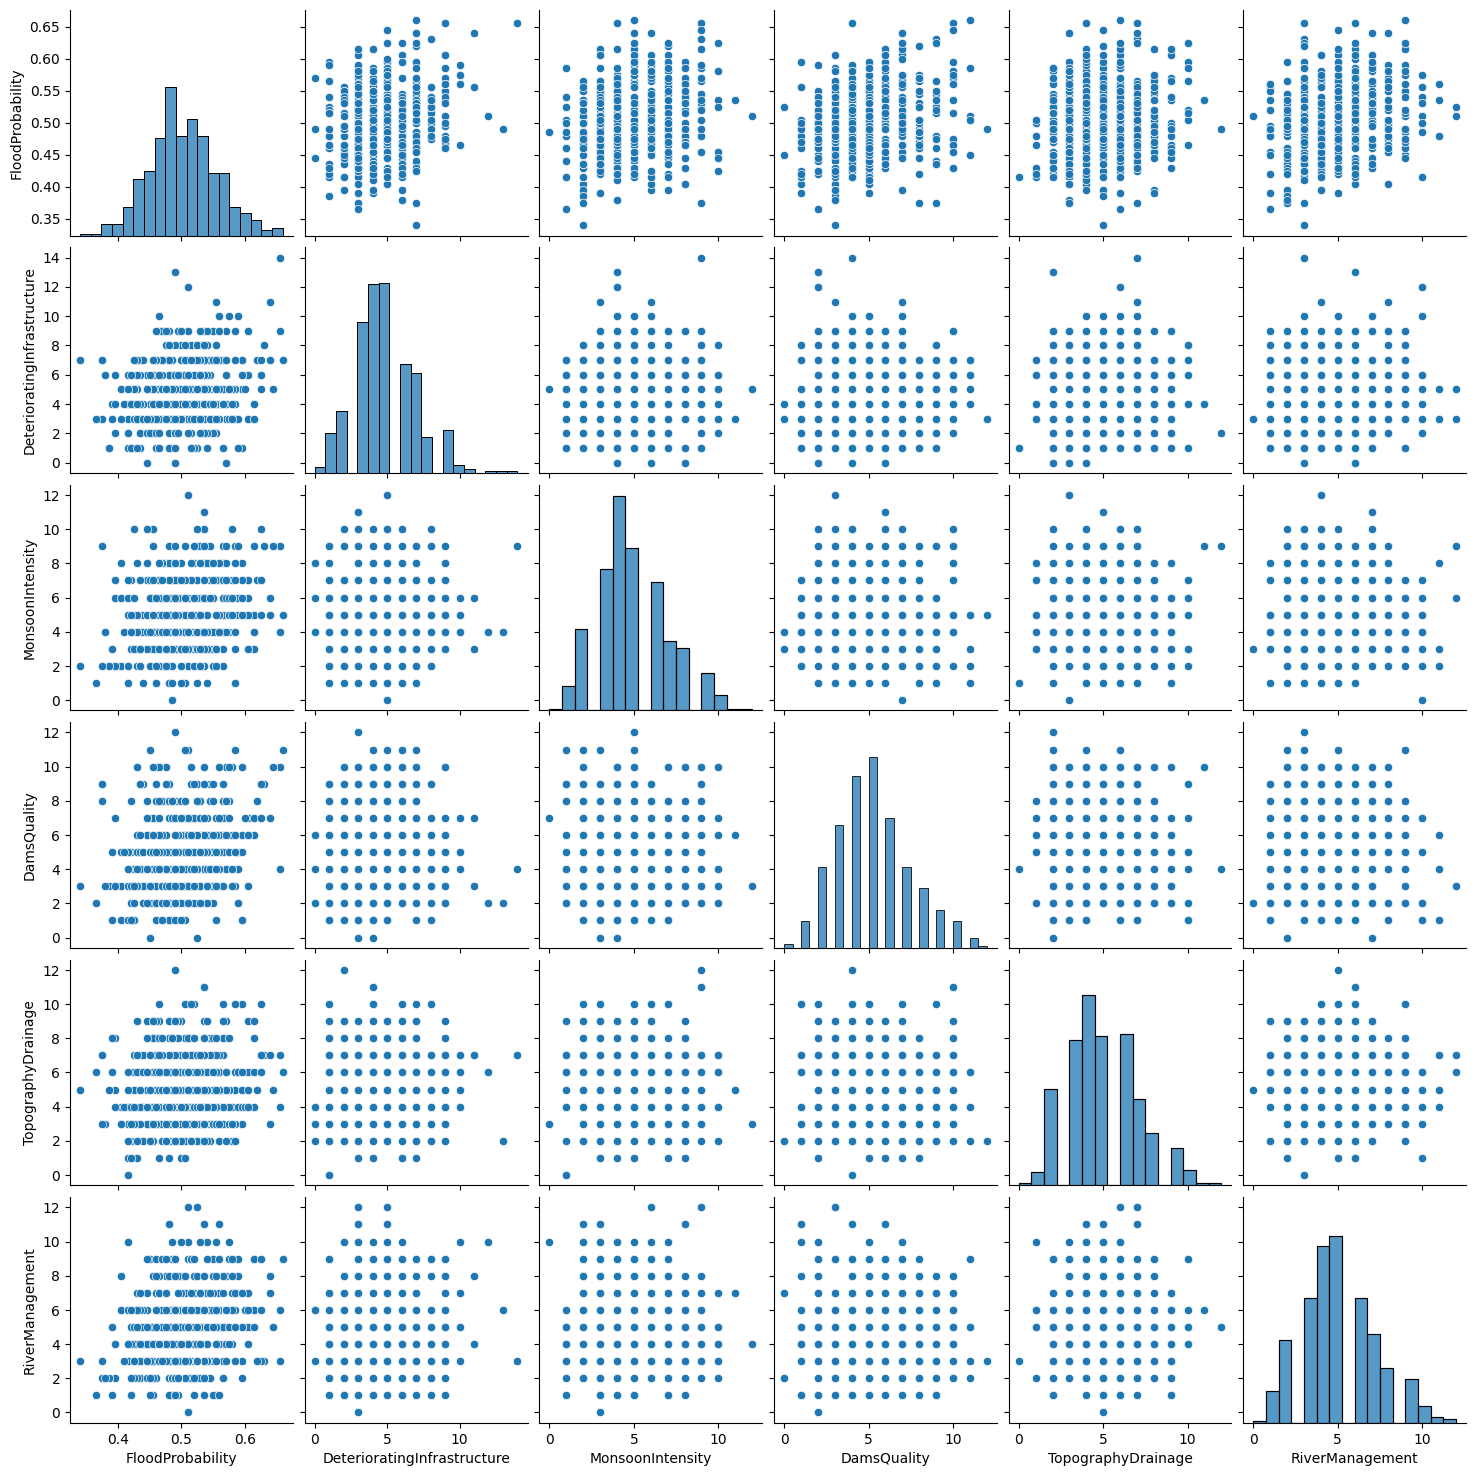

In [21]:
# Create pair plot
sns.pairplot(df_train_filtered_sample)
plt.show()

**Observations**

The weak correlations (correlation < 0.5) in the correlation matrix indicates that there is no clear  linear relationship between the features. Looking at the pair plot, there are weak linear positive relationships between some of the features and the flood probability.

A regression model that works well with non-linear relationships will likely model this data better than a basic linear regression model.

# Model Building and Training

**Feature Selection**
As there is a large number of features in the original dataset, select the top 10 features that are correlated to the probability of floods occuring.

In [15]:
features = df_train.corr(numeric_only=True)['FloodProbability'].sort_values(ascending=False).index

In [16]:
features = np.array(features[features != 'FloodProbability'])
print("Top 10 features selected are: ", features)

Top 10 features selected are:  ['DeterioratingInfrastructure' 'MonsoonIntensity' 'DamsQuality'
 'TopographyDrainage' 'RiverManagement' 'Siltation' 'PopulationScore'
 'Landslides' 'ClimateChange' 'Deforestation' 'WetlandLoss'
 'AgriculturalPractices' 'IneffectiveDisasterPreparedness'
 'PoliticalFactors' 'Watersheds' 'InadequatePlanning' 'Urbanization'
 'DrainageSystems' 'Encroachments' 'CoastalVulnerability' 'id']


**Model Option 1: Linear Regression Model**

The data will be modeled by a linear regression model.
* Options that **account for multilinear regression** are also tested
* The model is adjusted to **remove any non-statistically significant features**

In [39]:
# Basic linear regression model - use r-squared to select best feature
best_lin_feature = None
best_lin_model = None
best_lin_rsquared = 0
for feature in features:
  if feature == 'FloodProbability':
    continue
  model_lin = smf.ols(formula='FloodProbability ~ ' + feature, data=df_train).fit()
  print("\tBasic linear model FloodProbability ~ " , feature , " has r-squared value of ", model_lin.rsquared)
  if model_lin.rsquared > best_lin_rsquared:
    best_lin_feature = feature
    best_lin_model = model_lin
    best_lin_rsquared = model_lin.rsquared

	Basic linear model FloodProbability ~  DeterioratingInfrastructure  has r-squared value of  0.03610264422901488
	Basic linear model FloodProbability ~  MonsoonIntensity  has r-squared value of  0.03575816415643762
	Basic linear model FloodProbability ~  DamsQuality  has r-squared value of  0.035342552092972324
	Basic linear model FloodProbability ~  TopographyDrainage  has r-squared value of  0.03520691036345813
	Basic linear model FloodProbability ~  RiverManagement  has r-squared value of  0.03501787832530223
	Basic linear model FloodProbability ~  Siltation  has r-squared value of  0.03489023220250753
	Basic linear model FloodProbability ~  PopulationScore  has r-squared value of  0.034554979924151685
	Basic linear model FloodProbability ~  Landslides  has r-squared value of  0.03435316339543204
	Basic linear model FloodProbability ~  ClimateChange  has r-squared value of  0.03413680831937249
	Basic linear model FloodProbability ~  Deforestation  has r-squared value of  0.033856337

In [76]:
print("The best basic linear model with no multilinear relationship is FloodProbability ~ ", best_lin_feature, " with r-squared value of ", best_lin_rsquared)

The best basic linear model with no multilinear relationship is FloodProbability ~  DeterioratingInfrastructure  with r-squared value of  0.03610264422901488


In [77]:
best_lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       FloodProbability   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                 4.187e+04
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:22:07   Log-Likelihood:             1.7606e+06
No. Observations:             1117957   AIC:                        -3.521e+06
Df Residuals:                 1117955   BIC:                        -3.521e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.4814      0.000   3927.454      0.000       0.481       0.482
DeterioratingInfrastructure     0.0047   2.29e-05    204.629      0.000       0.005       0.005
==============================================================================
Omnibus:                      467.275   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              453.656
Skew:                           0.037   Prob(JB):                     3.09e-99
Kurtosis:                       2.934   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model summary shows that p-value is < 0.05, supporting that the Deteriorating Infrastructure feature is significant.

In [40]:
# Linear regression model that addresses multilinearity
formula = 'FloodProbability ~ ' + features[0]
for feature in features[1: ]:
  formula += ' + ' + feature
model_lin_multilin = smf.ols(formula=formula, data=df_train).fit()
print(model_lin_multilin.summary())

                            OLS Regression Results                            
Dep. Variable:       FloodProbability   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 3.046e+05
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:35:07   Log-Likelihood:             2.7820e+06
No. Observations:             1117957   AIC:                        -5.564e+06
Df Residuals:                 1117936   BIC:                        -5.564e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

As shown above, all the features have p-value < 0.05, therefore all of them are significant and will be kept in the model.

In [41]:
# best multilinear model
formula = 'FloodProbability ~ ' + features[0]
for feature in features[1: ]:
  formula += ' + ' + feature
best_model_lin_multilin = smf.ols(formula=formula, data=df_train).fit()
print(best_model_lin_multilin.summary())

                            OLS Regression Results                            
Dep. Variable:       FloodProbability   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 3.046e+05
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:35:17   Log-Likelihood:             2.7820e+06
No. Observations:             1117957   AIC:                        -5.564e+06
Df Residuals:                 1117936   BIC:                        -5.564e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

**Model Option 2: Polynomial Regression Model**

As the data is not binomial, the data will be modeled by a polyomial regression model next.
* Options that **account for multilinear regression** are also tested
* The model's hyperparameter is the polynomial degree. This is **tuned to the best r-squared result**.

In [18]:
# Basic polynomial regression model
best_degree = None
best_poly_model = None
all_poly_rsquared = []
best_poly_rsquared = 0
tmp_poly_formula = 'FloodProbability ~ ' + features[0]
for n in range(10):
    if n > 0:
        tmp_poly_formula += f' + np.power({features[0]}, {n+1})'
    tmp_model = smf.ols(formula=tmp_poly_formula, data=df_train).fit()
    tmp_r_squared = tmp_model.rsquared
    print("\tBasic polynomial model ", tmp_poly_formula , " has r-squared value of ", tmp_r_squared)
    all_poly_rsquared.append(tmp_r_squared)
    if tmp_r_squared > best_poly_rsquared:
        best_degree = n+1
        best_poly_model = tmp_model
        best_poly_rsquared = tmp_r_squared

	Basic polynomial model  FloodProbability ~ DeterioratingInfrastructure  has r-squared value of  0.03610264422901488
	Basic polynomial model  FloodProbability ~ DeterioratingInfrastructure + np.power(DeterioratingInfrastructure, 2)  has r-squared value of  0.03671914818714661
	Basic polynomial model  FloodProbability ~ DeterioratingInfrastructure + np.power(DeterioratingInfrastructure, 2) + np.power(DeterioratingInfrastructure, 3)  has r-squared value of  0.03672270825729618
	Basic polynomial model  FloodProbability ~ DeterioratingInfrastructure + np.power(DeterioratingInfrastructure, 2) + np.power(DeterioratingInfrastructure, 3) + np.power(DeterioratingInfrastructure, 4)  has r-squared value of  0.03675309155572137
	Basic polynomial model  FloodProbability ~ DeterioratingInfrastructure + np.power(DeterioratingInfrastructure, 2) + np.power(DeterioratingInfrastructure, 3) + np.power(DeterioratingInfrastructure, 4) + np.power(DeterioratingInfrastructure, 5)  has r-squared value of  0.036

In [19]:
print("The best basic polynomial model without addressing multilinearity is using degree", best_degree, " with r-squared value of ", best_poly_rsquared)
print("The mse is ", best_poly_model.mse_resid, ", the msa is ", np.mean(np.abs(best_poly_model.resid)))

The best basic polynomial model without addressing multilinearity is using degree 10  with r-squared value of  0.03678330439111577
The mse is  0.0025079135302261057 , the msa is  0.04023151528479134


<function matplotlib.pyplot.show(close=None, block=None)>

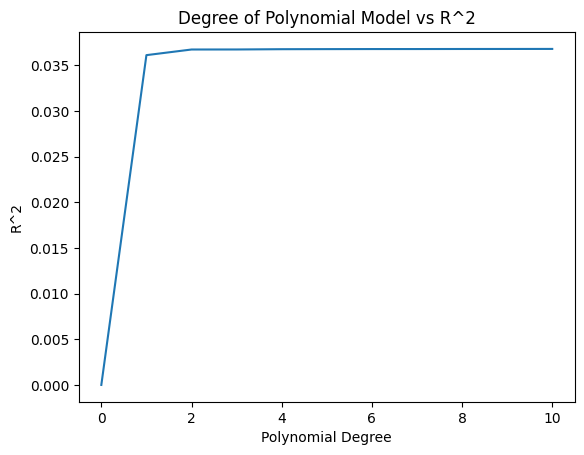

In [34]:
plt.plot(range(11), [0] + all_poly_rsquared)
plt.title("Degree of Polynomial Model vs R^2")
plt.xlabel("Polynomial Degree")
plt.ylabel("R^2")
plt.show

Observing the graph of r-squared vs. polynomial degree, it is likely that the above result may not be valid, as the model is likely overfitting on the training data when the polynomial degree is larger than 2.

In [21]:
# center the data around 0.5 probability of flooding prior to using it for the model
df_train['FloodProbabilityCentered'] = df_train['FloodProbability'] - 0.5

# split into train and validation set at ratio of 0.8 : 0.2
df_poly_xtrain, df_poly_xval, df_poly_ytrain, df_poly_yval = train_test_split(
    df_train[features], df_train['FloodProbabilityCentered'],
    train_size=0.8, random_state=0)

In [22]:
# Polynomial model that addresses multilinearity
best_poly_multi_degree = None
best_poly_multi_model = None
all_poly_multi_rsquared = []
best_poly_multi_rsquared = 0
poly_multi_mse = 0
poly_multi_msa = 0
for n in range(2): # limit n degree to maximum 2
    tmp_model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=n+1, include_bias=False)),
        ('ridge_reg', Ridge(alpha=1))
    ])
    tmp_model.fit(df_poly_xtrain, df_poly_ytrain)
    df_poly_ypred = tmp_model.predict(df_poly_xval)
    tmp_r_squared = r2_score(df_poly_yval, df_poly_ypred)
    print("\Polynomial model of degree ", n+1 , " and address for multilinearity has r-squared value of ", tmp_r_squared)
    all_poly_multi_rsquared.append(tmp_r_squared)
    if tmp_r_squared > best_poly_multi_rsquared:
        best_poly_multi_degree = n+1
        best_poly_multi_model = tmp_model
        best_poly_multi_rsquared = tmp_r_squared
        poly_multi_mse = mean_squared_error(df_poly_yval, df_poly_ypred)
        poly_multi_msa = mean_absolute_error(df_poly_yval, df_poly_ypred)

<>:16: SyntaxWarning: invalid escape sequence '\P'
<>:16: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-3454169939.py:16: SyntaxWarning: invalid escape sequence '\P'
  print("\Polynomial model of degree ", n+1 , " and address for multilinearity has r-squared value of ", tmp_r_squared)


\Polynomial model of degree  1  and address for multilinearity has r-squared value of  0.8443390609273703
\Polynomial model of degree  2  and address for multilinearity has r-squared value of  0.8448649331938038


In [24]:
print("The best basic polynomial model with multilinear relationship addressed is using degree", best_poly_multi_degree, " with r-squared value of ", best_poly_multi_rsquared)
print("The mse is ", poly_multi_mse, ", the msa is ", poly_multi_msa)

The best basic polynomial model with multilinear relationship addressed is using degree 2  with r-squared value of  0.8448649331938038
The mse is  0.0004032117329314141 , the msa is  0.015862105131482892


<function matplotlib.pyplot.show(close=None, block=None)>

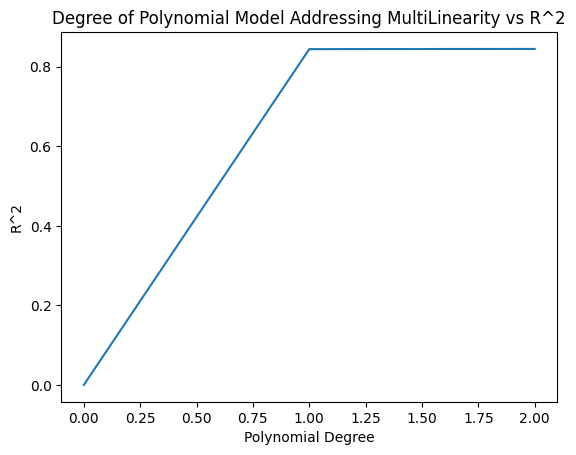

In [37]:
plt.plot(range(3), [0] + all_poly_multi_rsquared)
plt.title("Degree of Polynomial Model Addressing MultiLinearity vs R^2")
plt.xlabel("Polynomial Degree")
plt.ylabel("R^2")
plt.show

# Summary of Results

As this was a regression learning task, the results are evaluated by comparing:
* Model r-squared value, MSE, MSA
* Model performance on test data

In [42]:
# Evaluation on test dataset
y_pred_lin_reg1 =  best_lin_model.predict(df_test[features])
y_pred_lin_reg2 = best_model_lin_multilin.predict(df_test[features])
y_pred_poly_reg1 = best_poly_model.predict(df_test[features])
y_pred_poly_reg2 = best_poly_multi_model.predict(df_test[features])


In [47]:
# adjust for recentering performed earlier
y_pred_poly_reg2 += 0.5

In [50]:
# generate files for submission to Kaggle to evaluate performance on test dataset
predictions = [y_pred_lin_reg1, y_pred_lin_reg2, y_pred_poly_reg1, y_pred_poly_reg2]
for i in range(len(predictions)):
  submission_csv = pd.DataFrame(df_test['id'])
  submission_csv['FloodProbability'] = predictions[i]
  submission_csv.to_csv('submission'+str(i)+'.csv', index=False)


The Kaggle results:
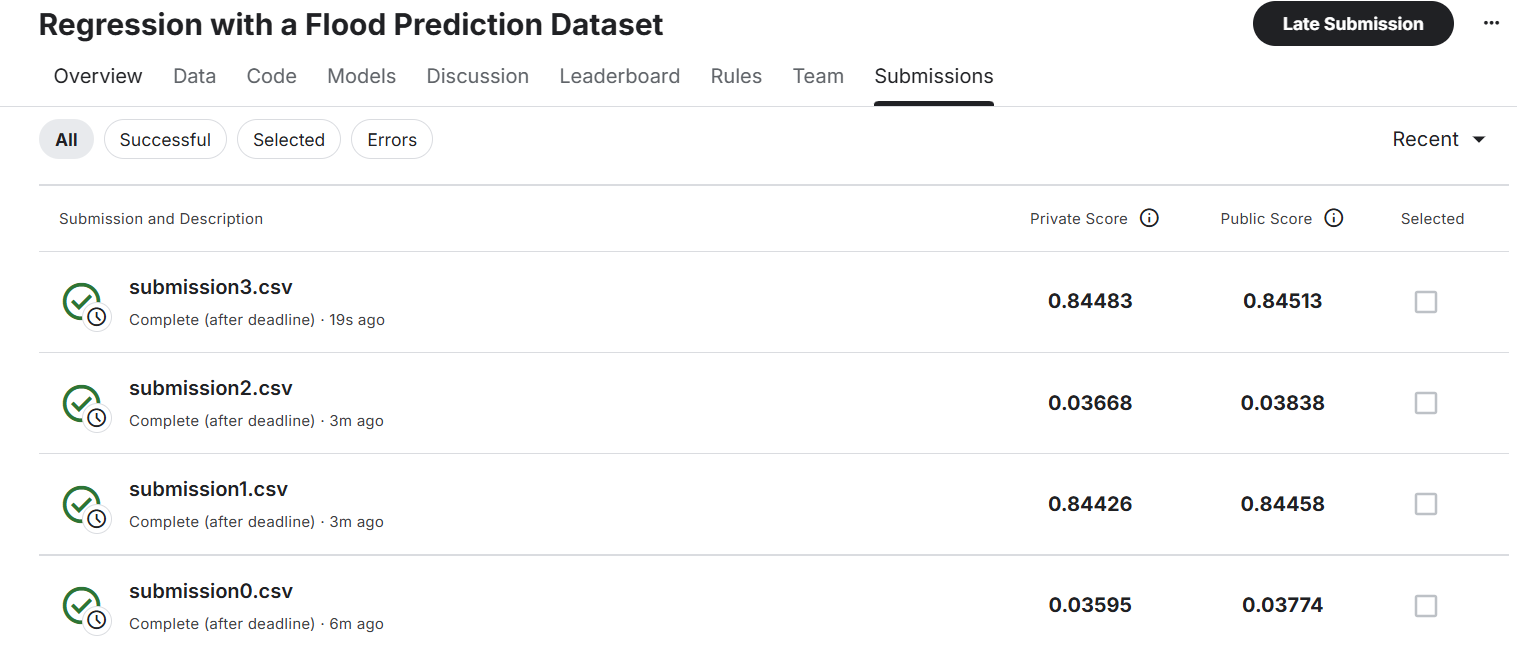

Visualizing the model building and training results in a table:

| Model Option | Additional Adjustments Applied | R-Squared Value | MSE | MSA |
| --- | --- | --- | --- | --- |
| Linear Regression | Feature engineering | 0.036 |
| Linear Regression | Feature engineering, addressing multilinear regression | 0.845 |
| Polynomial Regression | Feature engineering, hyperparameter tuning | 0.03678330439111577 | 0.0025079135302261057 | 0.04023151528479134
| Polynomial Regression | Feature engineering, hyperparameter tuning, addressing multilinear regression| 0.8448649331938038 | 0.0004032117329314141 | 0.015862105131482892

Visualizing the model testing results in a table:

| Model Option | Additional Adjustments Applied | Testing Score |
| --- | --- | --- |
| Linear Regression | Feature engineering | 0.03595 |
| Linear Regression | Feature engineering, addressing multilinear regression | 0.84426 |
| Polynomial Regression | Feature engineering, hyperparameter tuning | 0.3668 |
| Polynomial Regression | Feature engineering, hyperparameter tuning, addressing multilinear regression| 0.84483 |

Comparing between the models, when multilinearity is not addressed, the polynomial regression model of degree 2 performs slightly better during training and in testing.

Oeverall, it is evident that regression models addressing multilinearity perform significantly better (approx 84% test score) than those that do not (approx 3.6% test score).



---



# Discussion & Conclusion

The poor model performance when multilinearity is not addressed could be because the relationship between the one top feature and the flood probability is not linear when multilinearity is present.

Amongst the two different regression models, the polynomial regression model of degree 2 performs slightly worse than the linear regression model in r-squared value during training, but performs slightly better in testing. This indicates that multilinearity was likely present in the data. Therefore, the conclusion is that tuning the model and addressing multilinearity when present, significantly improves the data. For this problem, both linear regression with multilinearity addressed and polynomial regression with multilinearity addressed are models with reasonablly good performance.

To improve the performance of the model, the following next steps can be considered:
* Augment the dataset with additional features of higher correlation to learn. This can be achieved by using additional external sources that have historical weather and flooding data. By incorporating more useful features, this can enhance the model's ability to generalize in the real world.
* Feature engineering (PCA) can be used to create new features from the dataset. By further reducing the dimensionality of the model, it can increase the model's training time and improve its performance.